In [1]:
%cd ../

/Users/sarchey1/paper/FederatedLearning


In [2]:
import warnings
warnings.simplefilter('ignore')

## ICASSP MNIST Experiment

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../algorithm1.png)

In [4]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

# from algorithm.penalty import *


from abc import ABC
from joblib import Parallel, delayed
import copy



class OptVar(ABC):
    def __init__(self, vectors):
        self.vectors = vectors
        
    def get_node_vectors(self, node):
        node_vectors = []
        for vec in self.vectors:
            node_vectors.append(vec[node])
        return node_vectors
    
    def set_node_vectors(self, node, node_vectors):
        for i, node_vec in enumerate(node_vectors):
            self.vectors[i][node] = node_vec
            
    def diff(self, var2):
        diff_vec = []
        for i, sub_w in enumerate(self.vectors):
            diff_vec.append(sub_w - var2.vectors[i])
        return OptVar(diff_vec)
    
    def mult(self, num):
        for i, sub_vec in enumerate(self.vectors):
            self.vectors[i] = num * sub_vec
    

class PrimalVar(OptVar):
    def __init__(self, primal_vectors, T_matrix, D):
        super(PrimalVar, self).__init__(primal_vectors)
        self.T_matrix = T_matrix
        self.D = D
            
    def update(self, new_u):
        hat_w = []
        for i, sub_w in enumerate(self.vectors):
            hat_w.append(sub_w - np.dot(self.T_matrix, np.dot(self.D.T, new_u.vectors[i])))
        return OptVar(hat_w)
    
class DualVar(OptVar):
    def __init__(self, dual_vectors, Sigma, D):
        super(DualVar, self).__init__(dual_vectors)
        self.Sigma = Sigma
        self.D = D
            
    def update(self, tilde_w):
        for i, sub_vec in enumerate(self.vectors):
            self.vectors[i] = sub_vec + np.dot(self.Sigma, np.dot(self.D, tilde_w.vectors[i]))

            
def primal_update(hat_w_i, datapoints, i):
    optimizer = datapoints[i]['optimizer']
    res = optimizer.optimize(
        datapoints[i]['features'], 
        datapoints[i]['label'], 
        hat_w_i, 
        datapoints[i]['degree'],
    )
    return res, i
    

            
def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(D), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    if np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2) > 1:
        print ('product norm', np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2))

    E, N = D.shape
#     m, n = datapoints[0]['features'].shape
    m = len(datapoints[0]['features'])
    n = np.sum(datapoints[0]['features'][0].shape)
    
    lambda_lasso1 = lambda_lasso
    lambda_lasso2 = lambda_lasso / 2

    if penalty_func_name == 'norm2':
        penalty_func1 = Norm2Pelanty(lambda_lasso1, weight_vec, Sigma, n)
        penalty_func2 = Norm2Pelanty(lambda_lasso2, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)
   
    elif penalty_func_name == 'sq_norm2':
        penalty_func = SquaredNorm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1
    model = datapoints[0]['optimizer'].model
    out1, in1 = model.linear1.in_features, model.linear1.out_features
    out2, in2 = model.linear2.in_features, model.linear2.out_features
    
    l1 = np.random.random(in1*out1)
    l2 = np.random.random(in2*out2)
    new_w = PrimalVar([
        np.array([l1 for i in range(N)]), 
        np.array([l2 for i in range(N)]),
    ], T_matrix, D)
    hat_w = np.copy(new_w)
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = DualVar([
        np.array([l1 for i in range(E)]),
        np.array([l2 for i in range(E)]),
    ], Sigma, D)
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        prev_w = copy.deepcopy(new_w)

        # algorithm 1, line 2
        hat_w = new_w.update(new_u)

        for i in samplingset:
            res, i = primal_update(hat_w.get_node_vectors(i), datapoints, i)
            new_w.set_node_vectors(i, res)
 
        for i in range(N):
            if i not in samplingset: 
                new_w.vectors[0][i] = hat_w.vectors[0][i]
                new_w.vectors[1][i] = hat_w.vectors[1][i]

        # algorithm 1, line 9
        tilde_w = new_w.diff(prev_w)
        tilde_w.mult(2)
        new_u.update(tilde_w)
        
        # algorithm 1, line 10
        new_u.vectors[0] = penalty_func1.update(new_u.vectors[0])
        new_u.vectors[1] = penalty_func2.update(new_u.vectors[1])
        

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            alg1_score = get_algorithm1_error(datapoints, new_w, samplingset)
            iteration_scores.append(alg1_score)

    # print (np.max(abs(new_w - prev_w)))
    
    for i in range(N):
        optimizer = datapoints[i]['optimizer']
        
        optimizer.model.linear1.weight.data = torch.from_numpy(
            np.array(new_w.vectors[0][i].reshape(in1, out1), dtype=np.float32))
        optimizer.model.linear2.weight.data = torch.from_numpy(
            np.array(new_w.vectors[1][i].reshape(in2, out2), dtype=np.float32))


    return iteration_scores, new_w, new_u


### Primal Update 

As you see in the algorithm picture, the primal update needs a optimizer operator for the sampling set (line 6). We have implemented the optimizers discussed in the paper, both the logistic loss and squared error loss optimizers implementations with pytorch is available, also we have implemented the squared error loss optimizer using the fixed point equation in the `Networked Linear Regression` section of the paper.  

In [5]:
# %load algorithm/optimizer.py 
import torch
import abc
import numpy as np

from abc import ABC
import torch.nn.functional as F

# The SimpleLinear which is for MNIST experiment
class SimpleLinear(torch.nn.Module):

    def __init__(self, h1=2048):
        super().__init__()
        self.linear1 = torch.nn.Linear(28*28, h1)
        self.linear2 = torch.nn.Linear(h1, 2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)


# The abstract optimizer model which should have model, optimizer, and criterion as the input
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        out1, in1 = self.model.linear1.in_features, self.model.linear1.out_features
        out2, in2 = self.model.linear2.in_features, self.model.linear2.out_features
        
        torch_old_weight0 = torch.from_numpy(np.array(old_weight[0], dtype=np.float32).reshape(in1, out1))
        torch_old_weight1 = torch.from_numpy(np.array(old_weight[1], dtype=np.float32).reshape(in2, out2))
        
        if np.sum(old_weight[0]) == 0:
            self.model.linear1.weight.data = torch.tensor(np.array(np.random.rand(in1*out1), dtype=np.float32).reshape(in1, out1))
            self.model.linear2.weight.data = torch.tensor(np.array(np.random.rand(in2*out2), dtype=np.float32).reshape(in2, out2))
        else:
            self.model.linear1.weight.data = torch.tensor(np.array(old_weight[0], dtype=np.float32).reshape(in1, out1))
            self.model.linear2.weight.data = torch.tensor(np.array(old_weight[1], dtype=np.float32).reshape(in2, out2))
            
        for iterinner in range(10):
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear1.weight.data - torch_old_weight0) ** 2)  # + 10000*torch.mean((model.linear.bias+0.5)**2)#model.linear.weight.norm(2)
            loss3 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear2.weight.data - torch_old_weight1) ** 2)
            loss = loss1 + loss2 + loss3
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            

        return [self.model.linear1.weight.data.numpy().ravel(), 
                self.model.linear2.weight.data.numpy().ravel()]


# The Linear optimizer model which is implemented by pytorch
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model, criterion):
#         criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)



### Dual Update 

As mentioned in the paper, the dual update has a penalty function(line 10) which is either norm1, norm2, or mocha.

In [6]:
# %load algorithm/penalty.py
import abc
import numpy as np

from abc import ABC


# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The squared norm2 penalty function
class SquaredNorm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(SquaredNorm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u
    
    

# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u


# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


## Load MNIST data

We also proposed an experiment based on the MNIST dataset. Here we have two different clusters $C_1, C_2$. In order to simulate an environment where the data on each node is generated from a different distribution, for each cluster two different numbers (out of 10 available classes) is selected (
$C_1 \in \{0, 1\}$ and $C_2 \in \{2, 3\}$).
Each node of the empirical graph stands for a simple neural network with two Linear layers in which the dimension of the first layer's input is 28*28 and its output is 1 (with Relu activation function), and also the last layer has the output with dimension 2 (and Softmax activation function).


The training images for each cluster are splitted equally to the nodes in that cluster. Thus, the only difference between the nodes in the clusters is their training datasets. First, by using TSNE the dimension of each image ($d=28*28$) is reduced to $d^\prime=2$. Suppose that the training features for the node $i$ is $[img_i^1 ,\cdots, img_i^P] \in R^{784*P}$
, so the embedded features can be expressed by $embedded_i = [embedded_i^1,\cdots,embedded_i^P] \in R^{2*P}$. For calculating the similarities between the nodes, in order to calculate a consistent distance between the nodes, we consider the sorted embedded features, so $embedded_i = sorted([embedded_i^1,\cdots,embedded_i^P])$. Then
$\forall i \in N $ and $\forall j \in N$ 
 \begin{equation*}
     dist(i, j) = \frac{1}{P} \sum_{k=1}^{P} (embedded_i^k - embedded_j^k)^2.
 \end{equation*}

For each node the 6 nearest neighbours (the ones with the lowest distances) is selected and the edge weight between nodes i and j is defined by $w_{ij} = e^{-dist(i,j)}$. 

In [7]:
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
import json
from sklearn.manifold import TSNE


def get_images():
    transforms = torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                     ])
    mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)

    dl = DataLoader(mnist_dataset)

    X = dl.dataset.data # (60000,28, 28)
    y = dl.dataset.targets #(60000)

    # normalize to have 0 ~ 1 range in each pixel

    X = X / 255.0
    
    cluster_nums = [[0, 1], [2, 3]]
    
    cluster_data0 = np.concatenate((np.where(y==cluster_nums[0][0])[0], np.where(y==cluster_nums[0][1])[0]))
    random.shuffle(cluster_data0)
    
    cluster_data1 = np.concatenate((np.where(y==cluster_nums[1][0])[0], np.where(y==cluster_nums[1][1])[0]))
    random.shuffle(cluster_data1)
    
    cluster_data = [
        cluster_data0,
        cluster_data1,
    ]
    
    all_cluster_data = np.concatenate((cluster_data0 , cluster_data1))
    selected_X = X[all_cluster_data].reshape(-1, 28*28)
    selected_embedded = TSNE(n_components=2, learning_rate='auto',
                            init='random').fit_transform(selected_X)
    
    all_embeded = np.zeros((len(X), 2))
    all_embeded[all_cluster_data] = selected_embedded
    return X, y, cluster_data, cluster_nums, all_embeded


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()

        return super(NpEncoder, self).default(obj)
    
    
def save_data():
    X, y, cluster_data, cluster_nums, all_embeded = get_images()

    saved_data = {
        'X': X.tolist(), 
        'y': y.tolist(),
        'cluster_data': cluster_data,
        'cluster_nums': cluster_nums,
        'all_embeded': all_embeded,
    }
    with open('./experiments/data/MNIST/mnist_data.json', 'w') as f:
        f.write(json.dumps(saved_data, cls=NpEncoder))
    
def loead_data():
    with open('./experiments/data/MNIST/mnist_data.json', 'r') as f:
        saved_data = json.load(f)
    
    X = torch.tensor(saved_data['X'])
    y = torch.tensor(saved_data['y'])
    cluster_data = np.array(saved_data['cluster_data'])
    cluster_nums = np.array(saved_data['cluster_nums'])
    all_embeded = np.array(saved_data['all_embeded'])
    
    return X, y, cluster_data, cluster_nums, all_embeded



## Build the graph

In [8]:
# from algorithm.optimizer import *

from scipy.spatial import cKDTree as KDTree

def KLdivergence(x, y):
    """Compute the Kullback-Leibler divergence between two multivariate samples.
    Parameters
    ----------
    x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
    y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
    Returns
    -------
    out : float
    The estimated Kullback-Leibler divergence D(P||Q).
    References
    ----------
    Pérez-Cruz, F. Kullback-Leibler divergence estimation of
    continuous distributions IEEE International Symposium on Information
    Theory, 2008.
    """

    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)


    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

    # Get the first two nearest neighbours for x, since the closest one is the
    # sample itself.
    r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
    s = ytree.query(x, k=1, eps=.01, p=2)[0]

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


def build_graph(cluster_sizes, X, y, cluster_data, all_embeded, num_neig=3, h1=200, scale=1.0):
    '''
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = np.sum(cluster_sizes)
    E = num_neig*N
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    feature_size = int(10000//cluster_sizes[0])
    train_size = int(feature_size*0.8)
    
    # create the data of each node needed for the algorithm 1 
    node_degrees = np.full(N, 1.0/num_neig)
#     np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    embeded_features = []
    cnt = 0
    for i, cluster_size in enumerate(cluster_sizes):
        for j in range(cluster_size):
            features = X[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            res = all_embeded[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            res = np.sort(res, axis=0)
            embeded_features.append(res)
            test_features = X[cluster_data[i][j*feature_size:(j+1)*feature_size]][train_size:]
            '''
            features: the feature vector of node i 
            '''
            label = y[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            test_label = y[cluster_data[i][j*feature_size:(j+1)*feature_size]][train_size:]
            
            label[label == cluster_nums[i][0]] = 0
            label[label == cluster_nums[i][1]] = 1
            
            test_label[test_label == cluster_nums[i][0]] = 0
            test_label[test_label == cluster_nums[i][1]] = 1
            '''
            label: the label of the node i
            '''
            
            true_labels.append(label)

            model = SimpleLinear(h1=h1) 
            criterion = torch.nn.CrossEntropyLoss()
            optimizer = TorchLinearOptimizer(model, criterion)
#             optimizer = TorchLogisticOptimizer(model)
#             features = Variable(torch.from_numpy(features)).to(torch.float32)
#             label = Variable(torch.from_numpy(label)).to(torch.float32) 
      
            '''
            model : the linear model for the node i 
            optimizer : the optimizer model for the node i 
            ''' 
            
            datapoints[cnt] = {
                'features': features,
                'embeded_features': res,
                'test_features': test_features,
                'degree': node_degrees[cnt],
                'label': label,
                'test_label': test_label,
                'optimizer': optimizer
            }
            cnt += 1
            
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    E = N*(N-1)
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            dist = KLdivergence(embeded_features[i], embeded_features[j])
            w = scale*np.exp(-dist)      
            B[cnt, i] = 1
            B[cnt, j] = -1
            weight_vec[cnt] = scale*np.exp(-dist)
            cnt += 1

#     weight_vec = (weight_vec - np.min(weight_vec)) / (np.max(weight_vec) - np.min(weight_vec))
    weight_vec = weight_vec[:cnt]
    B = B[:cnt, :]
    

    return B, weight_vec, np.array(true_labels), datapoints


### Compare Results

As the result we compare the MSE of Algorithm 1 with plain linear regression 
and decision tree regression

In [9]:
# %load results/compare_results.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error



def get_algorithm1_error(datapoints, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    
    true_labels = []
    test_true_labels = []
    pred_labels = []
    test_pred_labels = []
    for i in range(len(datapoints)):
        features = datapoints[i]['features']
        label = datapoints[i]['label'].ravel().detach().numpy()
        true_labels.append(label)
        
        pred_label = datapoints[i]['optimizer'].model(features)
        pred_label = torch.argmax(pred_label, axis=1).ravel().detach().numpy() 
        pred_labels.append(pred_label)
        
        
        test_features = datapoints[i]['test_features']
        test_label = datapoints[i]['test_label'].ravel().detach().numpy()
        test_true_labels.append(test_label)
        
        test_pred_label = datapoints[i]['optimizer'].model(test_features)
        test_pred_label = torch.argmax(test_pred_label, axis=1).ravel().detach().numpy() 
        test_pred_labels.append(test_pred_label)

    pred_labels = np.array(pred_labels).ravel()
    true_labels = np.array(true_labels).ravel()
    
    test_pred_labels = np.array(test_pred_labels).ravel()
    test_true_labels = np.array(test_true_labels).ravel()
    
    all_labels = np.concatenate((true_labels, test_true_labels))
    all_pred_labels = np.concatenate((pred_labels, test_pred_labels))
    
    alg1_MSE = {'total': len(np.where(all_labels == all_pred_labels)[0]) / len(all_pred_labels),
                'train': len(np.where(true_labels == pred_labels)[0]) / len(pred_labels),
                'test': len(np.where(test_true_labels == test_pred_labels)[0]) / len(test_pred_labels),
               }

    return alg1_MSE


### Similarity graph with Two Clusters

In [10]:
%%capture
# from sparsebm import generate_SBM_dataset
import networkx as nx


def get_graph_data(X, y, cluster_data, all_embeded, n_neig=3, h1=200, scale=10):
    '''
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    cluster_sizes = [100, 100]
    cluster_sizes = [20, 20]
    
    return build_graph(cluster_sizes, X, y, cluster_data, all_embeded, n_neig, h1, scale)


# save_data()
X, y, cluster_data, cluster_nums, all_embeded = loead_data()

In [11]:
# penalty_func = 'norm2'
# for lambda_lasso in [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0]:
#     print(lambda_lasso)
#     B, weight_vec, true_labels, datapoints = get_graph_data(X, y, cluster_data, all_embeded, n_neig=5, h1=1)
#     E, N = B.shape
#     samplingset = [i for i in range(N-1)]
#     _, predicted_w, predicted_u = algorithm_1(200, B, weight_vec, datapoints, true_labels, samplingset, 
#                              lambda_lasso, penalty_func)
#     alg1_score = get_algorithm1_error(datapoints, predicted_w, samplingset)
#     print(alg1_score)
#     print()

In [14]:
penalty_func = 'norm2'
B, weight_vec, true_labels, datapoints = get_graph_data(X, y, cluster_data, all_embeded, n_neig=6, h1=1)
selected_e = np.where(weight_vec > np.quantile(weight_vec, 0.5))[0]
weight_vec = weight_vec[selected_e]
B = B[selected_e, :]
E, N = B.shape
samplingset = [i for i in range(N)]
for lambda_lasso in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 100000.0]:
    print(lambda_lasso)
    for item in datapoints:
        model = SimpleLinear(h1=h1) 
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = TorchLinearOptimizer(model, criterion)
        datapoints[item]['optimizer'] = optimizer
    _, predicted_w, predicted_u = algorithm_1(100, B, weight_vec, datapoints, true_labels, samplingset, 
                             lambda_lasso, penalty_func)
    alg1_score = get_algorithm1_error(datapoints, predicted_w, samplingset)
    print(alg1_score)
    print()

0.0
{'total': 0.47715, 'train': 0.476375, 'test': 0.48025}

0.1
{'total': 0.9711, 'train': 0.9754375, 'test': 0.95375}

0.2
{'total': 0.9832, 'train': 0.9875625, 'test': 0.96575}

0.3
{'total': 0.9962, 'train': 0.9996875, 'test': 0.98225}

0.4
{'total': 0.98345, 'train': 0.9874375, 'test': 0.9675}

0.5
{'total': 0.99555, 'train': 0.9991875, 'test': 0.981}

0.6
{'total': 0.9842, 'train': 0.9880625, 'test': 0.96875}

0.7
{'total': 0.9596, 'train': 0.9625, 'test': 0.948}

0.8
{'total': 0.94705, 'train': 0.9516875, 'test': 0.9285}

0.9
{'total': 0.972, 'train': 0.975125, 'test': 0.9595}

1.0
{'total': 0.94775, 'train': 0.951375, 'test': 0.93325}

100000.0
{'total': 0.9577, 'train': 0.9585625, 'test': 0.95425}



In [16]:
B, weight_vec, true_labels, datapoints = get_graph_data(X, y, cluster_data, all_embeded, n_neig=7, h1=1, scale=1.0)
E, N = B.shape
samplingset = [i for i in range(N)]
lambda_lasso = 0.3

N = len(datapoints)
t_test_scores = {}
edge_data = {}
for treshold in [0.7, 0.5, 0.3, 0.0]:
    if treshold == 0:
        selected_B = B
        selected_W = weight_vec
    else:
        selected_e = np.where(weight_vec > np.quantile(weight_vec, treshold))[0]
        selected_W = weight_vec[selected_e]
        selected_B = B[selected_e, :]
    inner = 0
    outer = 0
    for item in selected_B:
        i = np.where(item == 1)[0]
        j = np.where(item == -1)[0]
        if i < N//2 and j < N//2:
            inner += 1
        elif i >= N//2 and j >= N//2:
            inner += 1
        else:
            outer += 1
    
    edge_data[treshold] = {
        'inner': inner,
        'outer': outer,
        'all': inner + outer
    }
    
    iterations_score, predicted_w, predicted_u = algorithm_1(200, selected_B, selected_W, datapoints, true_labels, samplingset, 
                             lambda_lasso, penalty_func, calculate_score=True)
    t_test_scores[treshold] = [item['test'] for item in iterations_score]
    
# with open('experiments/data/MNIST/alg1_treshhold_acc.json', 'w') as f:
#     f.write(json.dumps(t_test_scores))
    
print(edge_data)

{0.7: {'inner': 234, 'outer': 0, 'all': 234}, 0.5: {'inner': 380, 'outer': 10, 'all': 390}, 0.3: {'inner': 380, 'outer': 166, 'all': 546}, 0.0: {'inner': 380, 'outer': 400, 'all': 780}}


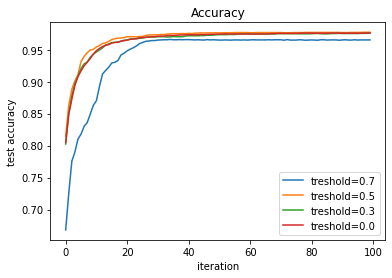

In [17]:
import matplotlib
import matplotlib.pyplot as plt

f = plt.figure()

for treshold in t_test_scores:
    scores = t_test_scores[treshold][:100]
    x = [i for i in range(len(scores))]
    plt.plot(x, scores, label='treshold=' + str(treshold))
plt.title('Accuracy')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("experiments/data/MNIST/treshhhold_graph.pdf", bbox_inches='tight')
plt.close()